In [4]:
%matplotlib inline

# Building a simple neural-network with Keras

**Author: Xavier Snelgrove**

This is a simple quick-start in performing digit recognition in a neural network in Keras, for a short tutorial at the University of Toronto. It is largely based on the `mnist_mlp.py` example from the Keras source.


## Install prerequisites
First steps (instructions for Mac or Linux). You need to install a recent version of Python, plus the packages `keras`, `numpy`, `matplotlib` and `jupyter`.

### Install a recent Python

If you haven't installed a recent Python I recommend installing via Homebrew on a Mac from http://brew.sh and then installing Python via `brew install python`.


### Configure a virtual environment

You can install the packages globally, but I suggest installing them in a `virtualenv` virtual environment that basically encapsulates a full isolated Python environment. First you'll need to install a Python package manager called `pip` thus:

    easy_install pip
    
(If you get a permissions error, try adding a `sudo` to the beginning, so `sudo easy_install pip`)

Now install virtualenv thus:

    pip install virtualenv

Navigate to your home directory `cd ~` and create a virtual environment. We'll call it `kerasenv`

    virtualenv kerasenv

Now, to switch your shell environment to be within the env:

    source kerasenv/bin/activate
    
Great: now you can install the other prerequisites into this environment.

    pip install numpy jupyter keras matplotlib
    

## Open a new notebook

Now that everything's installed, you can open one of these web-based Python environments with the following command:

    ipython notebook
    
Create a new Python notebook from the "New" menu at the top-right:

<img src="newnotebook.png">

You should now be able to run Python in your browser!

## Time to build a neural network!
First let's import some prerequisites

In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

## Load training data

In [40]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

max_train = 2000

X_train = X_train[:max_train]
y_train = y_train[:max_train]
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

max_test = 300
X_test = X_test[:max_test]
y_test = y_test[:max_test]

X_train original shape (2000, 28, 28)
y_train original shape (2000,)


Let's look at some examples of the training data

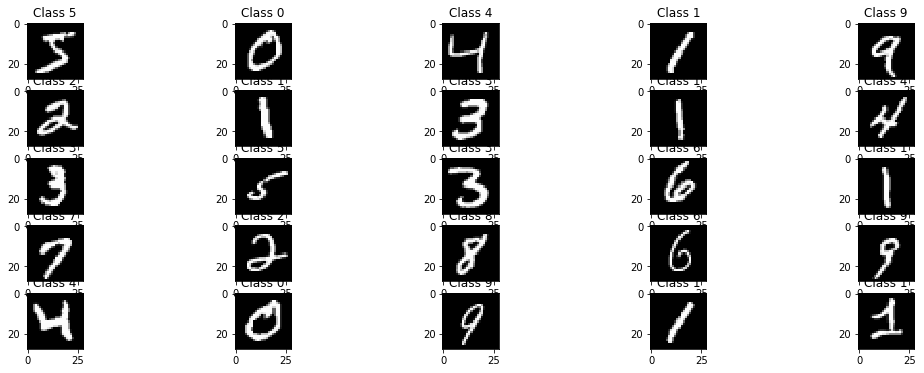

In [41]:
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))

## Format the data for training
Our neural-network is going to take a single vector for each training example, so we need to reshape the input so that each 28x28 image becomes a single 784 dimensional vector. We'll also scale the inputs to be in the range [0-1] rather than [0-255]

In [42]:
X_train = X_train.reshape(max_train, 784)
X_test = X_test.reshape(max_test, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (2000, 784)
Testing matrix shape (300, 784)


In [43]:
img_rows, img_cols = 28, 28

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

Modify the target matrices to be in the one-hot format, i.e.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```

In [44]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

# Build the neural network
Build the neural-network. Here we'll do a simple 3 layer fully connected network.
<img src="figure.png" />

## Conventional ANN model

In [46]:
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu')) # An "activation" is just a non-linear function applied to the output
                              # of the layer above. Here, with a "rectified linear unit",
                              # we clamp all values below 0 to 0.
                           
model.add(Dropout(0.2))   # Dropout helps protect the model from memorizing or "overfitting" the training data
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
        
model.add(Dense(nb_classes, activation='softmax', name='preds'))

## CNN model

In [54]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax', name='preds'))

In [55]:
import tensorflow as tf

K.get_session().close()
K.set_session(tf.Session())
K.get_session().run(tf.global_variables_initializer())

## Compile the model
Keras is built on top of Theano (and now TensorFlow as well), both packages that allow you to define a *computation graph* in Python, which they then compile and run efficiently on the CPU or GPU without the overhead of the Python interpreter.

When compiing a model, Keras asks you to specify your **loss function** and your **optimizer**. The loss function we'll use here is called *categorical crossentropy*, and is a loss function well-suited to comparing two probability distributions.

Here our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0 for everything else. The cross-entropy is a measure of how different your predicted distribution is from the target distribution. [More detail at Wikipedia](https://en.wikipedia.org/wiki/Cross_entropy)

The optimizer helps determine how quickly the model learns, how resistent it is to getting "stuck" or "blowing up". We won't discuss this in too much detail, but "adam" is often a good choice (developed here at U of T).

In [56]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model!
This is the fun part: you can feed the training data loaded in earlier into this model and it will learn to classify digits

In [57]:
max_epochs = 8

In [58]:
hist = model.fit(X_train, Y_train,
          batch_size=128, nb_epoch=max_epochs, verbose=1,
          validation_split = 0.1)

/home/dmitry/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 1800 samples, validate on 200 samples
Epoch 1/8
1800/1800 [==============================] - 5s 3ms/step - loss: 1.5514 - acc: 0.5183 - val_loss: 0.5726 - val_acc: 0.8000
Epoch 2/8
1800/1800 [==============================] - 3s 2ms/step - loss: 0.7320 - acc: 0.7783 - val_loss: 0.3588 - val_acc: 0.8900
Epoch 3/8
1800/1800 [==============================] - 3s 2ms/step - loss: 0.5440 - acc: 0.8356 - val_loss: 0.2703 - val_acc: 0.9250
Epoch 4/8
1800/1800 [==============================] - 3s 2ms/step - loss: 0.4361 - acc: 0.8711 - val_loss: 0.2024 - val_acc: 0.9400
Epoch 5/8
1800/1800 [==============================] - 3s 2ms/step - loss: 0.3290 - acc: 0.9044 - val_loss: 0.1625 - val_acc: 0.9550
Epoch 6/8
1800/1800 [==============================] - 3s 2ms/step - loss: 0.2886 - acc: 0.9106 - val_loss: 0.1580 - val_acc: 0.9550
Epoch 7/8
1800/1800 [==============================] - 3s 2ms/step - loss: 0.2161 - acc: 0.9389 - val_loss: 0.1410 - val_acc: 0.9450
Epoch 8/8
1800/1800 [=

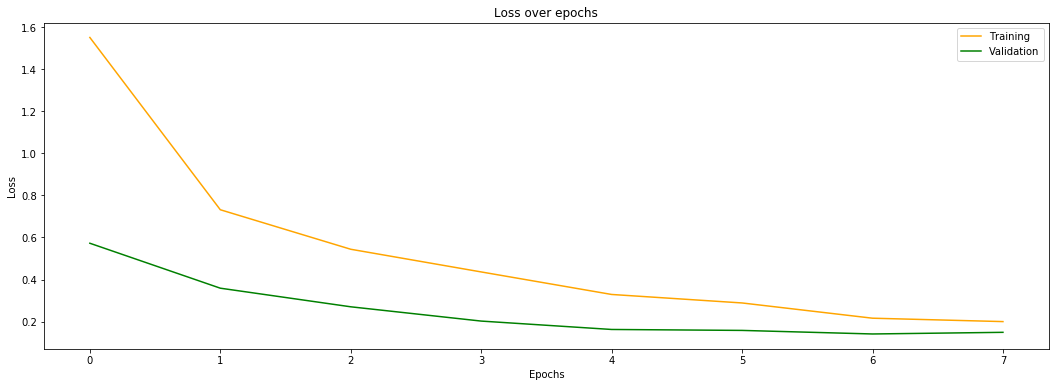

In [60]:
epochs = range(max_epochs)
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

import matplotlib.pyplot as plt

plt.plot(epochs, train_loss, label='Training', color='orange')
plt.plot(epochs, val_loss, label='Validation', color='green')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

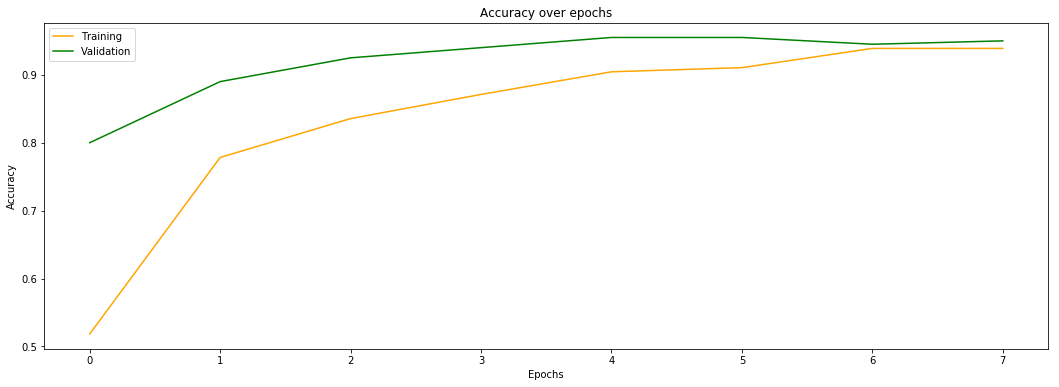

In [61]:
epochs = range(max_epochs)
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']

import matplotlib.pyplot as plt

plt.plot(epochs, train_acc, label='Training', color='orange')
plt.plot(epochs, val_acc, label='Validation', color='green')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Finally, evaluate its performance

In [62]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

300/300 [==============================] - 0s 991us/step
Test score: 0.14078316688537598
Test accuracy: 0.9666666674613953


### Inspecting the output

It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong.

In [63]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

Correct classifications


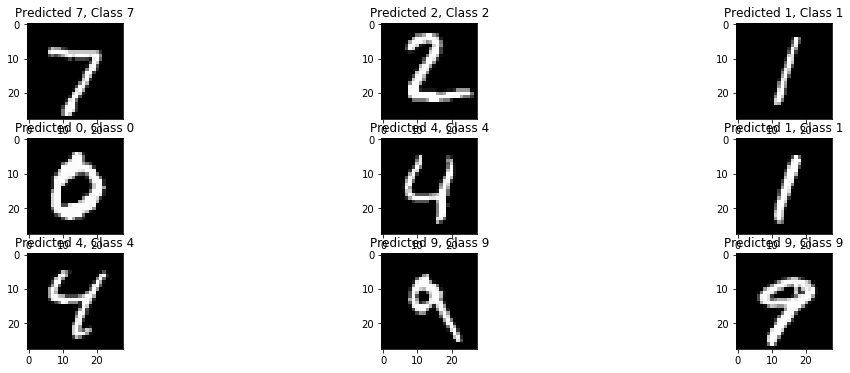

In [64]:
print('Correct classifications')

plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))

Incorrect classifications:


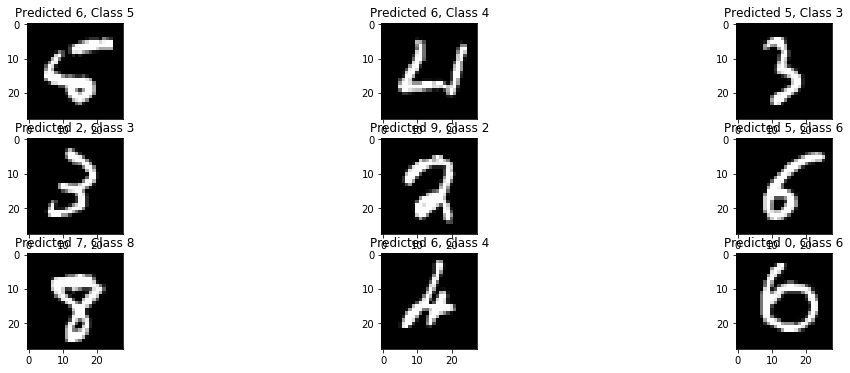

In [65]:
print('Incorrect classifications:')   

plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

## Confusion matrix

In [66]:
from sklearn.metrics import confusion_matrix
import numpy as np

confusion = confusion_matrix(y_test, predicted_classes)
print(confusion)

[[24  0  0  0  0  0  0  0  0  0]
 [ 0 41  0  0  0  0  0  0  0  0]
 [ 0  0 31  0  0  0  0  0  0  1]
 [ 0  0  1 22  0  1  0  0  0  0]
 [ 0  0  0  0 35  0  2  0  0  0]
 [ 0  0  0  0  0 28  1  0  0  0]
 [ 1  0  0  0  0  1 22  0  0  0]
 [ 0  0  0  0  0  0  0 34  0  0]
 [ 0  0  0  0  1  0  0  1 19  0]
 [ 0  0  0  0  0  0  0  0  0 34]]


In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_plot(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap="Greens")
    plt.show()

<Figure size 1296x432 with 0 Axes>

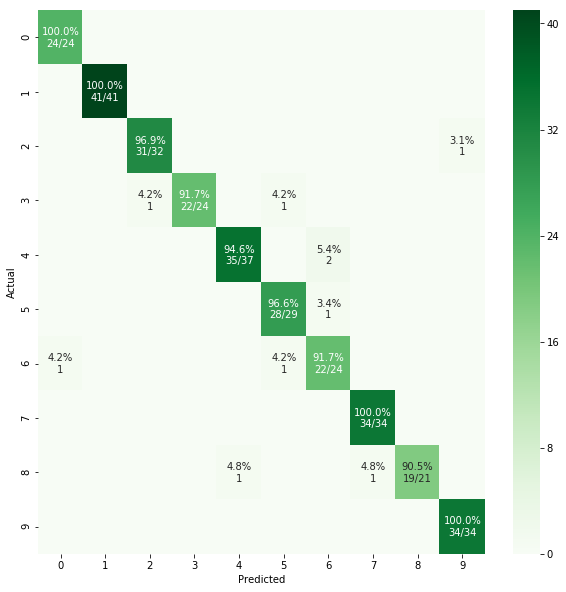

In [68]:
plt.clf()
cm_plot(y_test, predicted_classes, labels=[0,1,2,3,4,5,6,7,8,9], ymap=None, figsize=(10,10))

## Pick a number

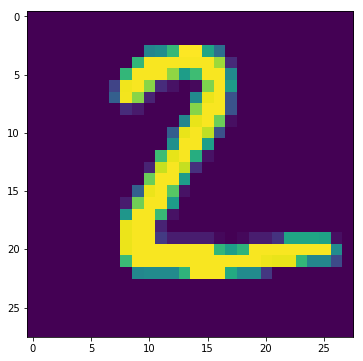

In [69]:
digit_to_instpect = 2

class_idx = 0
indices = np.where(y_test[:] == digit_to_instpect)[0]

# pick some random input from here.
idx = indices[0]

# Lets sanity check the picked image.
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

symbol_img = X_test[idx].reshape(28,28)
plt.imshow(symbol_img)

## Generate a saliency map

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7ff0af267da0>>
Traceback (most recent call last):
  File "/home/dmitry/anaconda3/envs/dl/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/dmitry/anaconda3/envs/dl/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7ff0af232400>>
Traceback (most recent call last):
  File "/home/dmitry/anaconda3/envs/dl/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/d

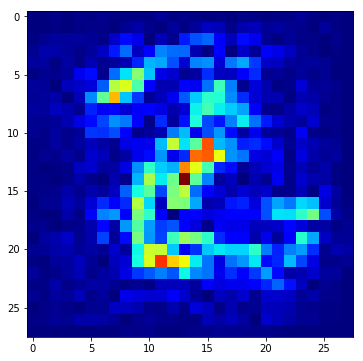

In [70]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'preds')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=X_test[idx])
# Plot with 'jet' colormap to visualize as a heatmap.
plt.imshow(grads.reshape(28,28), cmap='jet')

# That's all!

There are lots of other great examples at the Keras homepage at http://keras.io and in the source code at https://github.com/fchollet/keras